## Implementing the forward model (Convolution) with cupy

In this notebook we will perform convolution in the FFT domain [see convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem).

The convolution theorem states that the convolution of two signals is the pointwise multiplication of the Fourier transform of the signals.  This is important because for large Kernel sizes it is much faster to take 2 fourier transforms, mulitply them, and take the inverse transform then it is to perform convolution in the spatial domain.  Many deconvolution algorithms, including the Richardson Lucy algorithm consist of a series of convolutions, thus the convolution theorem is important for both convolution and deconvolution. 

1.  Learn how to implement convolution using FFTs
2.  Learn how to manage FFT memory with cupy
3.  Purposely run out of memory and think through strategies to deal with high memory use 

## Inspect memory, define array size and memory management strategy

In this example we will be generating a simulated image.  So in this block we define the size of our image.

To perform a convolution in the FFT domain we need arrays for an image, a PSF, a shifted PSF, FFTs of the image and PSF, the product FFT, the inverse FFT (the result).  In addition each FFT uses a temporary buffer apr. the size of the image.  Thus 9 copies of the array are needed for FFT convolution.  

We check how much memory is on our GPU, then compute the problem size (9 times the image size).

Adjust the image size to reduce or increase the problem size.  Try running the notebook

1,  With a problem size less than the total GPU memory
2.  With a problem size greater than the total GPU memory.

For the larger problem size try running with ```manage_memory``` False and True

In [1]:
from skimage.io import imread
import decon_helper
import cupy as cp
import numpy as np
from tnia.plotting.projections import show_xy_zy_max
from tnia.deconvolution.pad import pad, unpad

mempool = cp.get_default_memory_pool()

total_gpu_memory = mempool

bpg=(1024**3)

available_gpu_memory = cp.cuda.Device(0).mem_info[0]
total_gpu_memory = cp.cuda.Device(0).mem_info[1]
print("Total GPU memory = {}".format(total_gpu_memory/bpg))
print("Available GPU memory = {}".format(available_gpu_memory/bpg))
print("At beginning, used = {}".format(mempool.used_bytes()/bpg))

xdim=512
ydim=512
zdim=128
bytes_per_pixel=4

array_size = xdim*ydim*zdim*bytes_per_pixel/bpg

manage_memory = False

print("Array size = {}".format(array_size))
print("Problem size = {} GB".format(array_size*9))

    

tnia available
stackview available
Total GPU memory = 7.7540283203125
Available GPU memory = 7.59130859375
At beginning, used = 0.0
Array size = 0.125
Problem size = 1.125 GB


## Load the Point Spread Function

float32 (128, 256, 256)


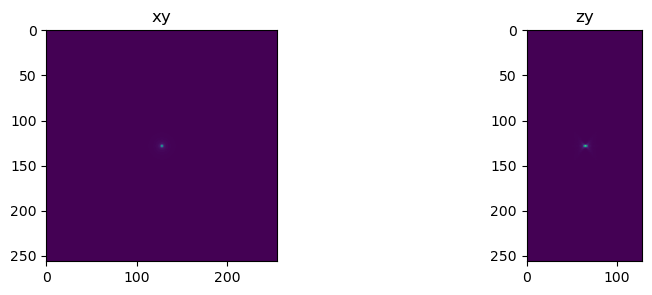

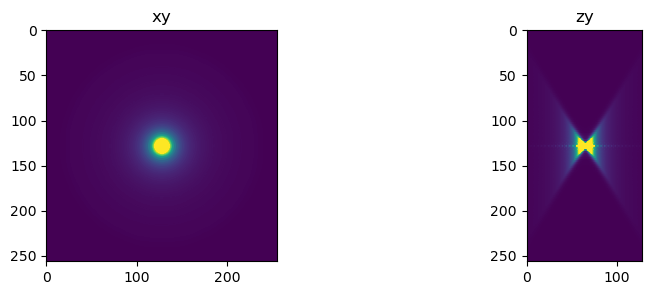

In [2]:
from decon_helper import image_path

psf_name='PSF-Bars-stack.tif'

psf=imread(image_path / psf_name).astype(np.float32)
psf=psf/psf.sum()

print(psf.dtype, psf.shape)

fig=show_xy_zy_max(psf, vmax=psf.max())
fig=show_xy_zy_max(psf, vmax=psf.max()/100)


## Create a simulated image

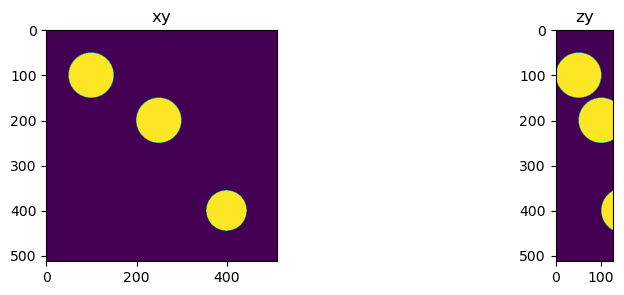

In [3]:
import raster_geometry as rg
from tnia.simulation.phantoms import add_small_to_large

phantom = np.zeros((zdim,ydim,xdim), dtype=np.float32)

r=50
size = [2*r, 2*r, 2*r]
sphere = rg.sphere(size, r).astype(np.float32)

x=100
y=100
z=50

add_small_to_large(phantom, sphere, 100, 100, 50)
add_small_to_large(phantom, sphere, 250, 200, 100)
add_small_to_large(phantom, sphere, 400, 400, 150)

fig = show_xy_zy_max(phantom)


## Pad the PSF to be the same size as the image

In order to do the point wise multiplication in the frequency domain, the PSF needs to be padded to the same size as the image in the spatial domain.  Then when transforming to the frequency domain both PSF and image will be the same size and pointwise multiplication will be possible. 

In [10]:
print('before padding',phantom.dtype, psf.dtype, phantom.shape, psf.shape)
psf, _ = pad(psf, phantom.shape, 'constant')
print('after padding',phantom.dtype, psf.dtype, phantom.shape, psf.shape)


before padding float32 float32 (128, 512, 512) (128, 512, 512)
after padding float32 float32 (128, 512, 512) (128, 512, 512)


## Perform Convolution in Fourier domain on the GPU

Convolution in the Fourier domain involves

1.  Moving image and PSF to the GPU
2.  Shifting the PSF so the center pixel is at the origin
3.  Performing FFT of the image and PSF
4.  Multiplying the FFT of the image with the FFT of the PSF
5.  Performing the inverse FFT of the result of step 4.

In the below cell, when ```manage_memory``` is ```True``` we delete GPU memory after it is no longer needed 

convolution without memory management
At beginning, used = 0.0
After moving phantom to GPU, used = 0.125
After moving psf to GPU, used = 0.25
After creating psf_shift, used = 0.375
After creating otf, used = 0.6259765625
After creating phantom_fft, used = 0.75146484375
After creating temp, used = 0.876953125
After creating convolved_cp, used = 1.12744140625


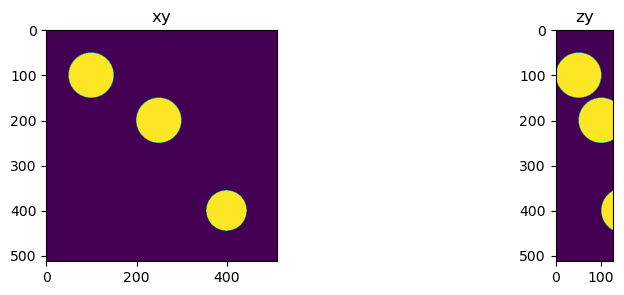

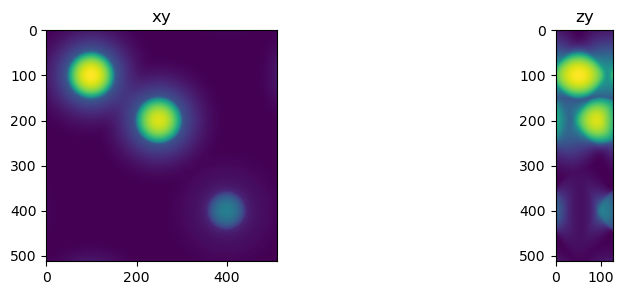

In [5]:

if not manage_memory:
    print('convolution without memory management')
    print("At beginning, used = {}".format(mempool.used_bytes()/bpg))
    phantom_cp = cp.array(phantom)
    print("After moving phantom to GPU, used = {}".format(mempool.used_bytes()/bpg))
    psf_cp = cp.array(psf)
    print("After moving psf to GPU, used = {}".format(mempool.used_bytes()/bpg))
    psf_cp_shift = cp.fft.ifftshift(psf_cp)
    print("After creating psf_shift, used = {}".format(mempool.used_bytes()/bpg))
    otf_cp = cp.fft.rfftn(psf_cp_shift)
    print("After creating otf, used = {}".format(mempool.used_bytes()/bpg))
    phantom_cp_fft = cp.fft.rfftn(phantom_cp)
    print("After creating phantom_fft, used = {}".format(mempool.used_bytes()/bpg))
    temp = phantom_cp_fft * otf_cp
    print("After creating temp, used = {}".format(mempool.used_bytes()/bpg))
    convolved_cp = cp.fft.irfftn(temp)
    print("After creating convolved_cp, used = {}".format(mempool.used_bytes()/bpg))
    convolved = cp.asnumpy(convolved_cp)
else:
    print('convolution with memory management')
    print("At beginning, used = {}".format(mempool.used_bytes()/1024**3))
    phantom_cp = cp.array(phantom)
    print("After moving phantom to GPU, used = {}".format(mempool.used_bytes()/bpg))
    psf_cp = cp.array(psf)
    print("After moving psf to GPU, used = {}".format(mempool.used_bytes()/bpg))
    psf_cp_shift = cp.fft.ifftshift(psf_cp)
    print("After creating psf_shift, used = {}".format(mempool.used_bytes()/1024**3))
    otf_cp = cp.fft.rfftn(psf_cp_shift)

    print("After creating otf, used = {}".format(mempool.used_bytes()/1024**3))
    del psf_cp
    del psf_cp_shift
    mempool.free_all_blocks()
    print("After deleting psf and shifted PSF, used = {}".format(mempool.used_bytes()/1024**3))


    phantom_cp_fft = cp.fft.rfftn(phantom_cp)
    print("After creating phantom_fft, used = {}".format(mempool.used_bytes()/1024**3))
    temp = phantom_cp_fft * otf_cp
    print("After creating temp, used = {}".format(mempool.used_bytes()/1024**3))
    del phantom_cp
    del phantom_cp_fft
    del otf_cp
    mempool.free_all_blocks()
    print("After deleting phantom_cp_fft and otf_cp = {}".format(mempool.used_bytes()/1024**3))
    convolved_cp = cp.fft.irfftn(temp)
    print("After creating convolved_cp, used = {}".format(mempool.used_bytes()/1024**3))
    convolved = cp.asnumpy(convolved_cp)
    print("After creating convolved, used = {}".format(mempool.used_bytes()/1024**3))


fig = show_xy_zy_max(phantom)
fig = show_xy_zy_max(convolved)

## Check memory use 

Here we check on the memory use both before and after attempting to free blocks.  We should not see any difference since all the buffers we created are in scope

In [6]:
print("After free_all_blocks, used = {}".format(mempool.used_bytes()/bpg))
mempool.free_all_blocks()
print("After free_all_blocks, used = {}".format(mempool.used_bytes()/bpg))


After free_all_blocks, used = 1.12744140625
After free_all_blocks, used = 1.12744140625


## Delete memory

In this block we delete memory, but we need to be careful.  Remember when we performed convolution we had a flag indicating whether we wanted to delete memory during the convolution process.  Thus some s may no longer exist.  In addition if our convolution failed we have no way of knowing how far along it got.  So before deleting memory check if the variable is still in scope.

In [7]:
try:
    # if phantom_cp defined, delete it
    if 'psf_cp' in locals():
        print("before psf_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print('psf_cp exists, deleting it')
        del psf_cp
        mempool.free_all_blocks()
        print("psf_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
    if 'phantom_cp' in locals():
        print("before phantom_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print('phantom_cp exists, deleting it')
        del phantom_cp
        mempool.free_all_blocks()
        print("phantom_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
    if 'psf_cp_shift' in locals():
        print("before psf_cp_shift deleted, used = {}".format(mempool.used_bytes()/bpg))
        print('psf_cp_shift exists, deleting it')
        del psf_cp_shift
        mempool.free_all_blocks()
        print("psf_cp_shift deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
    if 'otf_cp' in locals():
        print("before otf_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print('otf_cp exists, deleting it')
        del otf_cp
        mempool.free_all_blocks()
        print("otf_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
    if 'phantom_cp_fft' in locals():
        print("before phantom_cp_fft deleted, used = {}".format(mempool.used_bytes()/bpg))
        print('phantom_cp_fft exists, deleting it')
        del phantom_cp_fft
        mempool.free_all_blocks()
        print("phantom_cp_fft deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
    if 'temp' in locals():
        print("before temp deleted, used = {}".format(mempool.used_bytes()/bpg)) 
        print('temp exists, deleting it')
        del temp
        mempool.free_all_blocks()
        print("temp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
    if 'convolved_cp' in locals():
        print("before convolved_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print('convolved_cp exists, deleting it')
        del convolved_cp
        mempool.free_all_blocks()
        print("convolved_cp deleted, used = {}".format(mempool.used_bytes()/bpg))
        print()
except Exception as e:
    print(e)

before psf_cp deleted, used = 1.12744140625
psf_cp exists, deleting it
psf_cp deleted, used = 1.00244140625

before phantom_cp deleted, used = 1.00244140625
phantom_cp exists, deleting it
phantom_cp deleted, used = 0.87744140625

before psf_cp_shift deleted, used = 0.87744140625
psf_cp_shift exists, deleting it
psf_cp_shift deleted, used = 0.75244140625

before otf_cp deleted, used = 0.75244140625
otf_cp exists, deleting it
otf_cp deleted, used = 0.626953125

before phantom_cp_fft deleted, used = 0.626953125
phantom_cp_fft exists, deleting it
phantom_cp_fft deleted, used = 0.50146484375

before temp deleted, used = 0.50146484375
temp exists, deleting it
temp deleted, used = 0.3759765625

before convolved_cp deleted, used = 0.3759765625
convolved_cp exists, deleting it
convolved_cp deleted, used = 0.2509765625



## Delete FFT cache

Finally to make sure we clear all our memory (in a real program we would want to the GPU memory to be cleared completely so it can be used for something else) we need to delete the GPU cache (tempory memorory used by the FFTs)

In [8]:
print("Before clearing fft cache, used = {}".format(mempool.used_bytes()/bpg))

 # explicitly clear the plan cache to avoid memory leak
cache = cp.fft.config.get_plan_cache()
cache.clear()

cp.get_default_memory_pool().free_all_blocks()
mempool.free_all_blocks()

print("After clearing fft cache, used = {}".format(mempool.used_bytes()/bpg))


Before clearing fft cache, used = 0.2509765625
After clearing fft cache, used = 0.0


## Look at image carefully

Scale the image in the axial direction and also reduce the gamma to enhance dim detail.  Do you see anything odd?

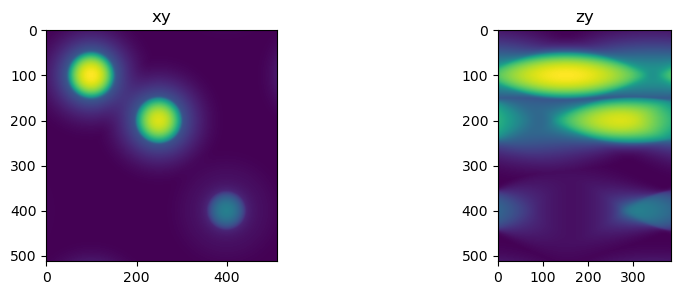

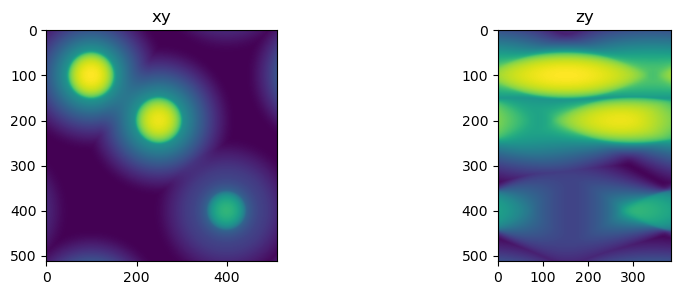

In [13]:
fig = show_xy_zy_max(convolved, sxy=1, sz=3)
fig = show_xy_zy_max(convolved, sxy=1, sz=3, gamma=0.5)

# Questions and exercise

1.  What is odd about the above image (hint look carefully at the edges especially near the edges)
2.  Can you modify the notebook to eliminate the 'wrap-around' artifact seen above?  (hint you will only have to change one block)
3.  After trying for a bit see answer below

# Answer

There is a wrap around artifact in the example (with default settings) because the 'signal space' we are dealing with is finite.  When implementing convolution with FFTs the image domain becomes 'circular' that is for pixels on the edge the 'adjacent' pixels are considered to be the pixel on the other side.  

For Python numpy arrays this is also true in the spatial domain.  For example for array a of size n, ```a[-1]=a[n-1]```, thus (in python) an implementation of convolution in the spatial domain would also have wrap around artifacts.

After thinking about this problem for a bit, you may realize there is an obvious solution.  Simply assign the values outside the boundaries a default value.  That is correct, however practically speaking we have to implement this solution somehow.  

One approach is to simply pad all our arrays, do the calculations, then at the end unpad to the original size.  See the below code which uses the image and psf size to compute a extended size which will be large enough to avoid wrap around.

In this case the final size of the convolved array will be bigger than the original and we likely will also want to crop out only the 'same' version.  You may have heard the terms 'valid', 'same' and 'full' in the context of convolutional neural networks.  The 'valid' region is the region that is not affected by wrap around convolution calculations, the 'same' region is the region the same size as the image, and the 'full' region is the size needed (after zero padding) to perform calculations without wrap around.

The code below extends the image using the 'full' strategy to avoid wrap around.  Try copying it and replacing the code within the cell that extends the PSF, (instead of extending just the PSF, we will extend image and PSF) then re-run the notebook.  Note this will also change the memory requirements.


In [ ]:

#extended_size=[phantom.shape[0]+psf.shape[0], phantom.shape[1]+psf.shape[1], phantom.shape[2]+psf.shape[2]]
#psf, _ = pad(psf, extended_size, 'constant')
#phantom, _ = pad(phantom, extended_size, 'constant')
#print('after padding',phantom.dtype, psf.dtype, phantom.shape, psf.shape)